In [1]:
from datetime import datetime
from IPython.display import Markdown as md
from IPython.display import display_markdown

todays_date = str(datetime.now().date())
month = datetime.now().strftime("%B")
year = str(datetime.now().year)

display_markdown('''# NBS mothly report for {month} {year}''')
md("# NBS mothly report for {} {}".format(month, year))

# NBS mothly report for February 2023

# An Overview

## The NBS project

The European Space Agency (ESA) is in charge for the distribution of data from the Sentinel satellite constellation. In order to maintain a reliable and sustainable data hub, the creation and operation of multiples data hubs is necessary. With the purpose of keeping and maintaining a reliable and online source of data from the ESA Sentinel constellation for an Area Of Interest (AOI) covering Norway, the Norwegian Space Agency (NOSA) funded the National Bakke Segment (NBS) project. The map below is indicating the AOI in red.  

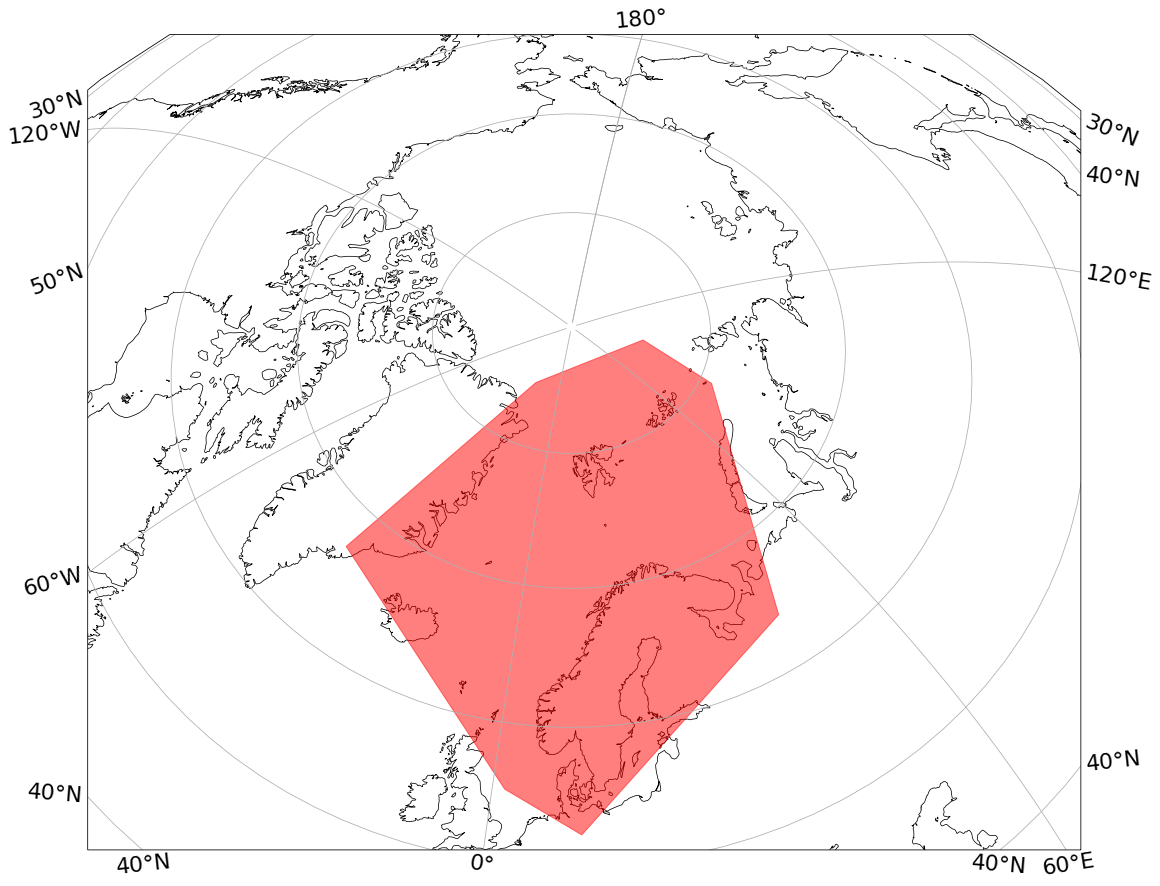

In [2]:
from shapely.geometry.polygon import Polygon
#from shapely import Polygon
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams.update({'font.size': 22})

bounds = [(-100., 160., 50., 90.)]
#plt.figure(figsize=(5, 3))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=10.0, central_latitude=60.0, globe=None))
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
#ax.add_feature(cfeature.STATES, linewidth=0.5)

# add in the polygon
polygon = Polygon([(-20.263238824222373,84.8852877777822),
                    (-36.25445787748578, 67.02581594412311), 
                    (11.148084316116405, 52.31593720759386), 
                    (45.98609725358305, 63.94940066151824), 
                    (89.96194965005743, 84.8341192704811), 
                    (-20.263238824222373, 84.8852877777822),
                    (-20.263238824222373, 84.8852877777822)])
ax.add_geometries([polygon], crs=ccrs.PlateCarree(), facecolor = 'r', edgecolor='red', alpha=0.5)
ax.gridlines(draw_labels=True)

plt.show()

Therefore, MET Norway was contracted for the operation of the NBS data. The NBS is implementd as a part of the operational infrastructure at MET Norway. As so it follows the normal procedures for planning, implementation and testing , and operationalisation. User access to the NBS is configured according to NOSA requirements. This includes the use of ESA's DHuS software for synchronization between ESA and user accessibility.

The present report is part of MET Norway duties to inform about its perfomance as operator of the NBS. Monthly reports will be created mothly to regularly comunicate the status of MET Norway's NBS.  

## The Sentinel products

The NBS project includes the management of the data received from Sentinel-1 (S1), Sentinel-2, Sentinel-3 (S3) and Sentinel-5p (S5p) satellites for the especified AOI. Each of the Sentinels has different operational modes for achieving images with different carachteristics. Those images can have different processing levels. The products included in the DHR are Level-1 images for all the Sentinels except for Sentinel-2. For which Level-1 (S2L1C) and Level-2 (S2L2A) are both included in the NBS.

## BackEnds and FrontEnds

As operator of NBS, the source of Sentinel data is ESA; and ESA spreads the Sentinel data trough the data hub Scihub (scihub.copernicus.eu).Scihub is ESA's FrontEnd (FE) for Sentinel data accesibility. MET Norway uses the DHS software for synchronization and creation of other FrontEnds. During the synchronization process a BackEnd (BE) is created. MET Norway is also running two FEs, colhub.met.no and colhub-archive.met.no. The colhub FE includes or will include all the products mentioned for Sentinel global products plus S3 marine products from Copernicus, S1 products from the Kongsberg Satellite Services (KSAT), and S2 Digital Elevation Model (DEM). The colhub-archive FE includes data from S1, S2L1C, S2L2A, S2DEM, S3, S5p products for the AOI. An important distiction between both FEs is that colhub-archive will allways maintain available online all the products for the AOI.  
 
In order to maintain an accountability on products synchronized from ESA's Scihub and available for users at the different FEs, it is necessary to understand the architecture of MET Norway's DHR.

## Quick summary

The table below shows a short overview of the NBS preformance operation during the last 30 days. The three different FEs and the BE are included. All columns represents the number of products in each portal excepting the last 3 columns. Those 3 columns represents the data flow from MET Norway to users through the portals where Volumes are measured in Tb. 


In [3]:
import pathlib
import datetime as dt
import pandas as pd
import copy
from myst_nb import glue

logsdir = pathlib.Path('../data')
hubs=['colhub_global', 'scihub', 'esahub_global', 'colhub_AOI']
products=['S1', 'S2L1C', 'S2L2A', 'S3', 'S5p']

data_FE = None
for h in hubs:
    csvfile = logsdir / f'products_in_{h}.csv'
    data_tmp = pd.read_csv(csvfile, header=None, names=['product', 'area', 'sensing_date', f'{h}'], parse_dates=['sensing_date'])
    # If several sensing date exist, keep the most recent one
    data_clean = copy.deepcopy(data_tmp.drop_duplicates(subset=['sensing_date', 'product', 'area'], keep='last'))
    if h == 'colhub_AOI':
        data_clean['area'] = 'colhub_aoi'
    if data_FE is None:
        data_FE = data_clean
    else:
        data_FE = data_FE.merge(data_clean, on=['sensing_date', 'product', 'area'], how='outer')
        
data_BE = None
areas = ['AOI']
for a in areas:
    for p in products:
        csvfile = logsdir / f'products_in_BE_{p}_{a}.csv'
        data_tmp = pd.read_csv(csvfile, header=None, names=['product', 'area', 'sensing_date', 'BE'], parse_dates=['sensing_date'])
        # If several sensing date exist, keep the most recent one
        data_clean = copy.deepcopy(data_tmp.drop_duplicates(subset=['sensing_date', 'product', 'area'], keep='last'))
        if a == 'AOI':
            data_clean['area'] = 'colhub_aoi'
        if data_BE is None:
            data_BE = data_clean
        else:
            data_BE = data_BE.append(data_clean)
            
data = data_FE.merge(data_BE, on=['sensing_date', 'product', 'area'], how='outer')
data.set_index('sensing_date', inplace=True)
data.sort_index(inplace=True)
data.fillna(0, inplace=True)

mask_s1 = (data['product'] == 'S1') & (data['area'] == 'colhub_aoi')
data_s1 = data.loc[mask_s1][-30:][['colhub_global', 'scihub', 'colhub_AOI', 'BE']].copy()
col_s1 = data_s1['colhub_global'].sum()
arc_s1 = data_s1['colhub_AOI'].sum()
sci_s1 = data_s1['scihub'].sum()
be_s1 = data_s1['BE'].sum()

mask_s2l1 = (data['product'] == 'S2L1C') & (data['area'] == 'colhub_aoi')
data_s2l1 = data.loc[mask_s2l1][-30:][['colhub_global', 'scihub', 'colhub_AOI', 'BE']].copy()
col_s2l1 = data_s2l1['colhub_global'].sum()
arc_s2l1 = data_s2l1['colhub_AOI'].sum()
sci_s2l1 = data_s2l1['scihub'].sum()
be_s2l1 = data_s2l1['BE'].sum()

mask_s2l2 = (data['product'] == 'S2L2A') & (data['area'] == 'colhub_aoi')
data_s2l2 = data.loc[mask_s2l2][-30:][['colhub_global', 'scihub', 'colhub_AOI', 'BE']].copy()
col_s2l2 = data_s2l2['colhub_global'].sum()
arc_s2l2 = data_s2l2['colhub_AOI'].sum()
sci_s2l2 = data_s2l2['scihub'].sum()
be_s2l2 = data_s2l2['BE'].sum()

mask_s3 = (data['product'] == 'S3') & (data['area'] == 'colhub_aoi')
data_s3 = data.loc[mask_s3][-30:][['colhub_global', 'scihub', 'colhub_AOI', 'BE']].copy()
col_s3 = data_s3['colhub_global'].sum()
arc_s3 = data_s3['colhub_AOI'].sum()
sci_s3 = data_s3['scihub'].sum()
be_s3 = data_s3['BE'].sum()

mask_s5 = (data['product'] == 'S5p') & (data['area'] == 'colhub_aoi')
data_s5 = data.loc[mask_s5][-30:][['colhub_global', 'scihub', 'colhub_AOI', 'BE']].copy()
col_s5 = data_s5['colhub_global'].sum()
arc_s5 = data_s5['colhub_AOI'].sum()
sci_s5 = data_s5['scihub'].sum()
be_s5 = data_s5['BE'].sum()

In [4]:
def get_product_type(product):
    if product[0:2] == 'S1':
        type = product.split('_')[2]
    elif product[0:2] == 'S2':
        type = product.split('_')[1]
        if not type.startswith('M'):
            type = 'Unknown'
    elif product[0:2] == 'S3':
        tmp = product.split('_')
        if tmp[1] == 'SL':
            type = 'SLSTR_L' + tmp[2]
        elif tmp[1] == 'SR':
            type = 'SRAL_L' + tmp[2]
        elif tmp[1] == 'OL':
            type = 'OLCI_L' + tmp[2]
        else:
            type = 'Unknown'
    else:
        type = 'Unknown'
    if 'DTERRENG' in product:
        type = type + '_DTERRENG'
    return type

def get_data(file):
    data = pd.read_csv(file, header=None, names=['download_time', 'user', 'product', 'size', 'download_duration']\
                        , parse_dates=['download_time'], index_col='download_time')
    data['satellite'] = data['product'].apply(lambda x: x[0:2])
    data['product_type'] = data['product'].apply(get_product_type)
    return data[data['product_type'] != 'Unknown']

csvfile = logsdir / 'NBS_frontend-global_outputs.csv'
nbs_global = get_data(csvfile)
#nbs_global.set_index('download_time', inplace=True)
nbs_global.sort_index(inplace=True)
nbs_global.fillna(0, inplace=True)
nbs_30 = nbs_global.loc[nbs_global.index >= dt.datetime.today() - dt.timedelta(days=30)].copy()

col_use = len(nbs_30['user'].unique())
col_nb = nbs_30.count()['product_type']
col_vol = nbs_30.sum()['size']/1024/1024/1024/1024 #in Tb


csvfile = logsdir / 'NBS_frontend-AOI_outputs.csv'
nbs_AOI = get_data(csvfile)
#nbs_AOI.set_index('download_time', inplace=True)
nbs_AOI.sort_index(inplace=True)
nbs_AOI.fillna(0, inplace=True)
aoi_30 = nbs_AOI.loc[nbs_AOI.index >= dt.datetime.today() - dt.timedelta(days=30)].copy()

arc_use = len(aoi_30['user'].unique())
arc_nb = aoi_30.count()['product_type']
arc_vol = aoi_30.sum()['size']/1024/1024/1024/1024 #in Tb

In [5]:
def read_dhus_logs_details(file):
    data = pd.read_csv(file, header=None, names=['day', 'product_type', 'action', 'volume', 'number', 'timeliness']\
                        , parse_dates=['day'], index_col=['day'])
    return data

def read_csv(file):
    data_tmp = pd.read_csv(file, header=None, names=['product_type', 'day', 'number', 'volume'], parse_dates=['day'], sep=';')
    # If several sensing date exist, keep the numbers only for the most recent script run (ie highest day index)
    data_clean = copy.deepcopy(data_tmp.drop_duplicates(subset=['product_type', 'day'], keep='last')).set_index('day').sort_index()
    data_clean['volume'] = data_clean['volume']/1024./1024
    return data_clean

data_s1 = read_dhus_logs_details(logsdir / 'S1-backend-AOI_inputs.csv')
data_s2l1c = read_dhus_logs_details(logsdir / 'S2L1C-backend-AOI_inputs.csv')
data_s2l2a = read_dhus_logs_details(logsdir / 'S2L2A-backend-AOI_inputs.csv')
data_s3 = read_dhus_logs_details(logsdir / 'S3-backend-AOI_inputs.csv')
data_s5 = read_dhus_logs_details(logsdir / 'S5p-backend-AOI_inputs.csv')
all_colhub = data_s1.append(data_s2l1c).append(data_s2l2a).append(data_s3).append(data_s5)

csvfile = pathlib.Path('../data/nb_products_volume_per_sensing_date.csv')
all_netcdf = read_csv(csvfile)

alle = pd.concat([all_colhub, all_netcdf])

all_vol_be = alle['volume'].sum()/1024 #in Tb

lately = alle[alle.index >= dt.datetime.today() - dt.timedelta(days=30)]
vol_be = lately['volume'].sum()/1024 #in Tb
nb_be = be_s1 + be_s2l1 + be_s2l2 + be_s3 + be_s5


In [6]:
glue("col_s1", col_s1)
glue("col_s2l1", col_s2l1)
glue("col_s2l2", col_s2l2)
glue("col_s3", col_s3)
glue("col_s5", col_s5)
glue("arc_s1", arc_s1)
glue("arc_s2l1", arc_s2l1)
glue("arc_s2l2", arc_s2l2)
glue("arc_s3", arc_s3)
glue("arc_s5", arc_s5)
glue("sci_s1", sci_s1)
glue("sci_s2l1", sci_s2l1)
glue("sci_s2l2", sci_s2l2)
glue("sci_s3", sci_s3)
glue("sci_s5", sci_s5)
glue("be_s1", be_s1)
glue("be_s2l1", be_s2l1)
glue("be_s2l2", be_s2l2)
glue("be_s3", be_s3)
glue("be_s5", be_s5)
glue("col_use", col_use)
glue("col_nb", col_nb)
glue("col_vol", col_vol)
glue("arc_use", arc_use)
glue("arc_nb", arc_nb)
glue("arc_vol", arc_vol)
glue("nb_be", nb_be)
glue("vol_be", vol_be)

7217

1626

3838

13815

7128

8312.0

1613.0

3814.0

13594.0

7012.0

7217.0

4191.0

4175.0

19327.0

7131.0

2174.0

168.0

1379.0

2690.0

2295.0

19

8945

4.916297596299955

2

75

0.09397890913260198

8706.0

9.415819679990818

| Portals | S1 | S2L1C | S2L2A | S3 | S5p | Nb of users | Nb of products | Volume |
|:---------:|:---------:|:--------:|:---------:|:----------:|:----------:|:-------------:|:---------:|:----------:|
| colhub.met.no | {glue:text}`col_s1:.0f` | {glue:text}`col_s2l1:.0f` | {glue:text}`col_s2l2:.0f` | {glue:text}`col_s3:.0f` | {glue:text}`col_s5:.0f` | {glue:text}`col_use` | {glue:text}`col_nb` | {glue:text}`col_vol:.3f` |
| colhub-archive.met.no | {glue:text}`arc_s1:.0f` | {glue:text}`arc_s2l1:.0f` | {glue:text}`arc_s2l2:.0f` | {glue:text}`arc_s3:.0f` | {glue:text}`arc_s5:.0f` | {glue:text}`arc_use` | {glue:text}`arc_nb` | {glue:text}`arc_vol:.3f` |
| scihub.copernicus.eu | {glue:text}`sci_s1:.0f` | {glue:text}`sci_s2l1:.0f` | {glue:text}`sci_s2l2:.0f` | {glue:text}`sci_s3:.0f` | {glue:text}`sci_s5:.0f` | - | - | - |
| MET Norway BE | {glue:text}`be_s1:.0f` | {glue:text}`be_s2l1:.0f` | {glue:text}`be_s2l2:.0f` | {glue:text}`be_s3:.0f` | {glue:text}`be_s5:.0f` | - | - | - |


In [7]:
md("Finally, the total amount of disk space dedicated to the NBS project, including either products in SAFE and NetCDF formats, represents {} Tb.".format(all_vol_be))

Finally, the total amount of disk space dedicated to the NBS project, including either products in SAFE and NetCDF formats, represents 3272.8793250643885 Tb.

In [8]:
# Monthly volumes (in Tb)
lately = alle[alle.index >= dt.datetime.today() - dt.timedelta(days=365)]
year = (lately['volume'].sum()/1024.)
after_year = year + all_vol_be
short = lately[lately.index <= dt.datetime.today() - dt.timedelta(days=123)]
m6 = (short['volume'].sum()/1024.)
after_6m = m6 + all_vol_be

In [9]:
md("Due to tracking the data ingested and produced for the NBS project in the last year it is possible to forcast the upcoming need for disk space. As long as data flows follows the same pattern than last year, in 6 months the total disk space will grow until {} Tb; while in 12 months it is forecasted to become {} Tb.".format(after_6m, after_year))

Due to tracking the data ingested and produced for the NBS project in the last year it is possible to forcast the upcoming need for disk space. As long as data flows follows the same pattern than last year, in 6 months the total disk space will grow until 4211.601594795664 Tb; while in 12 months it is forecasted to become 4409.0885917219875 Tb.